## Main code

### Libraries and Modules

In [1]:
import sys
import math
import glob
import os
import time
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi
import cv2

import import_ipynb
import voronoi_constructor as vor_build
import vertices_assembler as assembler
import i_o

importing Jupyter notebook from voronoi_constructor.ipynb
importing Jupyter notebook from node_linker.ipynb
importing Jupyter notebook from solver.ipynb
importing Jupyter notebook from vertices_assembler.ipynb
importing Jupyter notebook from i_o.ipynb


### Global Parameters

In [2]:
parameters = {"robots"      : 11,
              "radius"      : 0.1,
              "movement"    : 0.1,
              "tolerance"   : 0.05,
              "deadlock_mov": 0.1,
              "previous"    : 1
             }

### General Options

In [3]:
options = { "palette"    : vor_build.colors(parameters["robots"]),
            "verbose"    : 0,
            "optimize"   : 0,
            "plot"       : 0,
            "save_image" : 0,
            "save_data"  : 0,
            "experiments": 1,
            "seed"       : 13,
            "critical"   : 65,
            "aggregate"  : 0,
            "path_data"  : "/home/leduin/Escritorio/Tesis/Resultados/Datos/",
            "path_image" : "/home/leduin/Escritorio/Tesis/Imagenes/"
          }

### Main Loop

In [4]:
def main_module(key):
    with open(options["path_data"]+"aga_"+key+".csv", "a") as file:
        if options["save_data"]:
            csv_writer = csv.writer(file)
        for experiment in range(options["experiments"]):
            # INITIALIZATION
            start_time = time.time()
            inst_experiment = experiment+options["seed"]
            pos = vor_build.pos_gen(parameters["robots"], inst_experiment)
            vor_init = Voronoi(pos["init"])
            vor_fin  = Voronoi(pos["fin"])
            robots_path = [] # To save the robots path along execution
            finished = np.all(pos["init"] == pos["fin"]) 
            # To save the traveled distance of each robot 
            traveled_distances = [0 for _ in range(parameters["robots"])]
            counter = 0 # For steps
            # COLLISION FREE CONFIGURATION
            if vor_build.collision(pos["init"], vor_init.ridge_points,
                                   parameters["radius"]):
                print('ERROR!: Change the initial configuration')
                print("Positions:", vor_init.ridge_points)
                break
            if vor_build.collision(pos["fin"], vor_fin.ridge_points,
                                   parameters["radius"]):
                print('ERROR!: Change the final configuration')
                print("Positions:", vor_fin.ridge_points)
                break
            # MAIN LOOP
            while not finished:
                #Final iteration
                if np.all(pos["init"] == pos["fin"]):
                    finished = True
                if options["verbose"]:
                    print("==================================================")
                    print('                    MAIN DATA')
                    print("==================================================")
                    print('Robots:\n', pos["init"],'\n')
                    print('Final positions:\n', pos["fin"],'\n')
                    print("Colors:")
                    for color in options["palette"]:
                        print(color)
                    print("\n")
                # Generate Voronoi Diagram for the current positions
                vor_init = Voronoi(pos["init"])
                # Generate the Voronoi Diagram and get the approximated values
                # of inf vertices
                vor_approx = vor_build.voronoi_approx(pos["init"], vor_init,
                                                      options["verbose"])
                # Assemble the vertices and get the ordered vertices
                vrtx_assembled = assembler.main(parameters["robots"], vor_init,
                                                vor_approx["edge"],
                                                options["verbose"])
                robots_path.append(pos["init"]) # Save the previous position
                # Generate the BVC
                bvc = vor_build.bvc_gen(pos, parameters["radius"], vor_approx,
                                        vrtx_assembled, robots_path, options)
                i_o.save_image(options, parameters, counter)
                
                # DEADLOCK TESTING
                bvc["closer"],list_deadlock=vor_build.deadlock_test(parameters,
                                                                    options,
                                                                    bvc, pos,
                                                                    counter,
                                                                    robots_path)
                if options["verbose"]:
                    print('\nRounds: ',counter)
                    print('\n*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*\n')
                counter += 1
                if counter == options["critical"]:
                    options["verbose"] = 1
                    options["plot"] = 1
                if counter > options["critical"] + options["aggregate"]:
                    options["verbose"] = 0
                    options["plot"] = 0
                # UPDATING POSITIONS
                internal_paths = bvc["closer"] - pos["init"]
                new_positions = []
                for i in range(parameters["robots"]):
                    if np.all(internal_paths[i] == 0):
                        # Paralyzed Robot for deadlock
                        if i in list_deadlock: 
                            new_positions.append(bvc["closer"][i])
                        else: # Reached target
                            new_positions.append(pos["fin"][i])
                    else:
                        candidate = (pos["init"][i] +
                                     ((internal_paths[i]
                                       / np.linalg.norm(internal_paths[i]))
                                      * parameters["movement"]))
                        # Reaching the final position
                        if vor_build.isBetween(pos["init"][i], candidate,
                                                 pos["fin"][i]):
                            new_positions.append(pos["fin"][i])
                            traveled_distances[i]+=np.linalg.norm(pos["init"][i]
                                                                  - pos["fin"][i])
                        # Internal Path less than alpha
                        elif (np.linalg.norm(internal_paths[i])
                              < parameters["movement"]):
                            new_positions.append(bvc["closer"][i])
                            traveled_distances[i]+=np.linalg.norm(internal_paths[i])
                        # Normal movement
                        else:
                            new_positions.append(candidate)
                            traveled_distances[i] += parameters["movement"]
                pos["init"] = np.array(new_positions)
            effectiveness = np.sum(pos["dist"]) / np.sum(traveled_distances)
            if options["save_data"]:
                csv_writer.writerow([parameters[key], inst_experiment,
                                     counter, time.time() - start_time,
                                     effectiveness])
            print('Experiment ' + str(inst_experiment) + " done!")

### Running for the stablished number of experiments

                    MAIN DATA
Robots:
 [[-0.41875802  0.6581208 ]
 [-0.88609361 -0.06835471]
 [-0.55563007 -0.53050074]
 [-0.3348083  -0.92980305]
 [ 0.23016297 -1.02844914]
 [ 0.41843465 -0.2395167 ]
 [ 0.78129894 -0.22081748]
 [ 0.72667275  0.36149668]
 [-0.06718512  0.17677202]
 [ 0.0585546   0.71105052]
 [-0.58072754  0.44352809]] 

Final positions:
 [[-4.73 -0.01]
 [-4.03 -2.59]
 [-2.17 -4.43]
 [ 0.52 -4.72]
 [ 2.85 -3.69]
 [ 4.35 -1.34]
 [ 4.42  1.29]
 [ 3.03  3.33]
 [ 0.55  4.63]
 [-2.01  4.11]
 [-3.96  2.36]] 

Colors:
red
orangered
goldenrod
yellowgreen
green
teal
aqua
blue
purple
magenta
maroon


List of vertex coordinates (including approximations) of Voronoi Diagram:

0 .- [-0.43250477 -0.09323425]
1 .- [-0.46942414  0.03010435]
2 .- [-0.08382573 -0.33403317]
3 .- [0.58519697 0.05450572]
4 .- [0.30607231 0.37086314]
5 .- [0.35183722 0.17418752]
6 .- [ 0.62436648 -0.70559138]
7 .- [-0.15740843  0.47994097]
8 .- [-0.28365844  0.38772908]
9 .- [-0.03350883 -0.50246824]
10 .- [

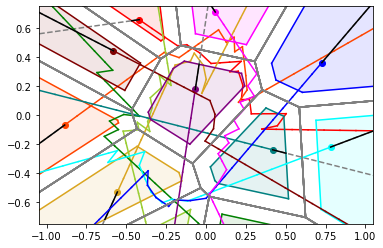

Distance from red to the closest point: 0.04797972978319727
Distance from the 1th previous point: 0.1377341474867948
Distance from orangered to the closest point: 3.3338836544298722
Distance from the 1th previous point: 3.433883654429872
Distance from goldenrod to the closest point: 0.2055507270687172
Distance from the 1th previous point: 0.30555072706871717
Distance from yellowgreen to the closest point: 0.4857022174217729
Distance from the 1th previous point: 0.5857022174217729
Distance from teal to the closest point: 0.08616752385101877
Distance from the 1th previous point: 0.15805308004435273
Distance from aqua to the closest point: 0.6511488120215716
Distance from the 1th previous point: 0.7511488120215716
Distance from purple to the closest point: 0.1752016221111128
Distance from the 1th previous point: 0.2752016221111128
Distance from magenta to the closest point: 0.3315950606814954
Distance from the 1th previous point: 0.4315950606814954
Closer positions: [[-0.46617177  0.65077

In [5]:
main_module("robots")

### One Parameter Analysis

In [15]:
parameter = "robots"
print("Working on",parameter,"...")
previous_value = parameters[parameter]
if parameter == "deadlock_mov":
    parameters[parameter] = 1
elif parameter == "tolerance":
    parameters[parameter] = 0.1
elif parameter == "movement":
    parameters[parameter] = 20
for i in range(10):
    print(parameter,"equal to",parameters[parameter],"...")
    main_module(parameter)
    if parameter == "tolerance":
        parameters[parameter] = round(parameters[parameter]+0.1,2)
    elif parameter == "movement":
        parameters[parameter] += 10 
    else:
        parameters[parameter] += 1
parameters[parameter] = previous_value

Working on num_robots ...
num_robots equal to 5 ...
num_robots equal to 6 ...
num_robots equal to 7 ...
num_robots equal to 8 ...


KeyboardInterrupt: 

### All Parameter Analysis

In [8]:
for parameter in parameters:
    print("Working on",parameter,"...")
    previous_value = parameters[parameter]
    if parameter == "deadlock_mov":
        parameters[parameter] = 1
    for i in range(10):
        print(parameter,"equal to",parameters[parameter],"...")
        main_module(parameter)
        parameters[parameter] += 1
    parameters[parameter] = previous_value

Working on robots ...
robots equal to 5 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!


voronoi_constructor.ipynb:16: RuntimeWarning: invalid value encountered in double_scalars
  },


Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 6 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment 4 done!
Experiment 5 done!
Experiment 6 done!
Experiment 7 done!
Experiment 8 done!
Experiment 9 done!
Experiment 10 done!
Experiment 11 done!
Experiment 12 done!
Experiment 13 done!
Experiment 14 done!
Experiment 15 done!
Experiment 16 done!
Experiment 17 done!
Experiment 18 done!
Experiment 19 done!
Experiment 20 done!
Experiment 21 done!
Experiment 22 done!
Experiment 23 done!
Experiment 24 done!
Experiment 25 done!
Experiment 26 done!
Experiment 27 done!
Experiment 28 done!
Experiment 29 done!
robots equal to 7 ...
Experiment 0 done!
Experiment 1 done!
Experiment 2 done!
Experiment 3 done!
Experiment

KeyboardInterrupt: 

### Generate Video

In [11]:
frameSize = (432, 288)

out = cv2.VideoWriter('/home/leduin/Desktop/Hub/Images/Simple/animation_simple_'
                      +str(robots)+'.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 4, frameSize)

for filename in sorted(glob.glob('/home/leduin/Desktop/Hub/Images/Simple/'
                                 +str(robots)+'/*.png'),
                       key=os.path.getmtime):
    img = cv2.imread(filename)
    out.write(img)

out.release()